# Creating a Fitness Function

## Import Modules

In [ ]:
# Matt's new edit
# Import Python Mobules
import os, json, time, argparse, cv2
import numpy as np
from sys import argv
import tensorflow as tf
import tensorflow.keras as keras


# Reduce warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Basic information 1
print("Modules: Imported")

# Print tensorflow version
print("Tensorflow version: ", tf.__version__)

2023-11-14 09:03:28.101403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/.singularity.d/libs
2023-11-14 09:03:28.101471: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Modules: Imported
Tensorflow version:  2.9.1


## Define Command Line Arguments

In [23]:
# Command line arguments

showPlots = False
buildEnv = False
Yext = None
Xext = None

def initParser():
    parser = argparse.ArgumentParser()
    parser.add_argument( '-runName', )
    parser.add_argument( "-verbose",  default = 0,  type=int, )
    parser.add_argument( "-save_model", default='True', type=str )
    parser.add_argument( "-model_loc", default='None',  type=str )
    parser.add_argument( "-data_loc", default='None',  type=str )
    parser.add_argument( "-val_loc", default='None',  type=str )

    # Training Variables
    parser.add_argument( "-start",    default = 0,  type=int, )
    parser.add_argument( "-stop",     default = 1,  type=int, )
    parser.add_argument( "-num_epochs",    default=1,       type=int )
    parser.add_argument( "-learning_rate", default=0.0001,  type=float )
    parser.add_argument( "-batch_size",    default=16,      type=int )
    parser.add_argument( "-keras_tuner",   default='False', type=str )

    # Data Generator
    parser.add_argument( "-data_gen", default='True',  type=str )
    parser.add_argument( "-noise",    default='True', type=str )
    parser.add_argument( "-warp_image",  default='True',  type=str )
    parser.add_argument( "-channel_offset",  default='True', type=str )

    # Core Model types
    parser.add_argument( "-model",   default = 'efficientNetB0', type=str)
    parser.add_argument( "-pool",    default = 'None',           type=str )
    parser.add_argument( "-weights", default = 'imagenet',       type=str )

    # Final layers
    parser.add_argument( "-f_depth", default = 8,  type=int )
    parser.add_argument( "-f_width", default = 32, type=int )
    parser.add_argument( "-f_activation", default = 'relu', type=str )
    parser.add_argument( "-output_activation", default = 'sigmoid' )

    return parser

parser = initParser()
print("Args: Defined")

Args: Defined


In [24]:
# Are you in the correct Working Directory? 

if buildEnv:
    print( f'Current Working Directory: {os.getcwd()}')
    print( 'Is this correct?')

    if False:
        os.chdir( 'galStuff/galaxyJSPAM/Neural_Network/')


## Establish if Building Environment or Script
Notice if code can see it's in a Jupyter Notebook Environment, it can create an artificial string of command line arguments.  This is convenient for testing the code in a Jupyter Notebook directly and changing variables on the fly.  Then when the Notebook is compiled as a python script, all changes can be stored.

In [52]:

# Am I in a jupyter notebook?
try:
    get_ipython().__class__.__name__
    buildEnv = True
    showPlots = True
    print ("In Building Environment")
    
    # Build Command Line Arguments
    cmdStr = ''
    cmdStr += ' -runName dl-s2-test'
    cmdStr += ' -start 0'
    cmdStr += ' -stop 1'
    cmdStr += ' -num_epochs 1'
    cmdStr += ' -batch_size 32'
    cmdStr += ' -verbose 1'
    # cmdStr += ' -save_model True'
    cmdStr += ' -data_loc data/dl-s2/dl-s2-10'
    cmdStr += ' -keras_tuner False'
    # cmdStr += ' -val_loc data/dl-s1/' 
    # cmdStr += ' -model efficientNetB1' 
    # cmdStr += ' -model_loc models/dl-s2-model-0.h5' 
    
    # Read string as if command line
    print( "CMD: ", cmdStr)
    args = parser.parse_args(cmdStr.split())


# Or am I in a python script?
except:
    
    # Read CMD arguments
    args = parser.parse_args()
    
    # Check for valid runName
    print( 'runName: ', args.runName )
    if args.runName == None:
        print( "WARNING:  runName required" )
        exit()

# Preprocess boolean cmd args
if args.save_model == 'True': args.save_model = True 
else:  args.save_model = False

if args.data_gen == 'True': args.data_gen = True 
else:  args.data_gen = False

if args.noise == 'True': args.noise = True 
else:  args.noise = False

if args.warp_image == 'True': args.warp_image = True 
else:  args.warp_image = False

if args.channel_offset == 'True': args.channel_offset = True 
else:  args.channel_offset = False

if 'test' in args.runName:
    buildEnv = True




print( "Args: Read")
print( args )

In Building Environment
CMD:   -runName dl-s2-test -start 0 -stop 1 -num_epochs 1 -batch_size 32 -verbose 1 -data_loc data/dl-s2/dl-s2-10 -keras_tuner False
Args: Read
Namespace(runName='dl-s2-test', verbose=1, save_model=True, model_loc='None', data_loc='data/dl-s2/dl-s2-10', val_loc='None', start=0, stop=1, num_epochs=1, learning_rate=0.0001, batch_size=32, keras_tuner='False', data_gen=True, noise=True, warp_image=True, channel_offset=True, model='efficientNetB0', pool='None', weights='imagenet', f_depth=8, f_width=32, f_activation='relu', output_activation='sigmoid')


## Define Device Strategy for Tensor Flow

In [39]:

# Read current devices
devices = tf.config.get_visible_devices()

# If no GPU found, use CPU
if len(devices) == 1:
    strategy = tf.distribute.OneDeviceStrategy('CPU') # Use local GPU

# Standard single GPU on backus
else:
    #tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:0') # Use local GPU

print( 'Devices:', devices )


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Define Useful Functions

In [40]:
def sliceKey( dictIn ):
    dictOut =  dictIn
    for k in dictOut:
        if type( dictOut[k] ) == type( 'string' ):
            if 'slice' in dictOut[k]:
                #print( k, dictOut[k] )
                tmp = dictOut[k].split('(')[1].split(')')[0].split(',')
                s = int( tmp[0] )
                e = int( tmp[1] )
                dictOut[k] = slice( s, e )
                #print( dictOut[k] )
    
    return dictOut 

def correlation(y_true, y_pred):
    y = y_pred.numpy()
    corr = np.corrcoef( y_true[:,0], y[:,0] )[0,1]
    return corr

    
# Load zipped images and data
def loadDLS1( args ):

    if args.val_loc[-1] != '/':  args.val_loc += '/'
    
    # Load Key for data
    with open( args.val_loc + 'data-key.json' ) as keyFile:
        key = json.load( keyFile )
    
        
    data = np.load( args.val_loc + 'data-all.npy')
    scores = data[:,key['score']].reshape( data.shape[0], 1 )
    img  = np.load( args.val_loc + 'img-all.npz' )['arr_0']
    
    # Rescale image values based on core model being used.
    if 'efficientNet' in args.model :
        img *= 255
    
    if buildEnv:
        print( 'img:  ', img.shape, np.amin(img), np.amax(img) )
        print( 'data: ', data.shape )
        print( 'scores: ', scores.shape )
    
    # If in building environment, only use 1/10th of data
    if buildEnv:
        img = img[::10]
        data = data[::10]
        scores = scores[::10]
    
    return img, scores

    
    

def loadData3( args ):
    # Load data info
    with open( args.data_loc + '.json' ) as keyFile:
        info = json.load( keyFile )        
    scores = np.array( [ k['score'] for k in info['info'] ] )
    scores = scores.reshape((-1,1))

    print( 'scores: ', scores.shape )
    print( 'type: ', type(scores) )
    print( 'type ele: ', type(scores[0,0]) )

    
    # Load images
    data = np.load( args.data_loc + '.npz' )['arr_0'].astype( np.float32 )
        
    if buildEnv:
        print( 'data: ', data.shape ) 


    if args.val_loc == None or args.val_loc == 'None':

        n = data.shape[0]
        # Grab every 5th run for testing

        # Print first info
        print( info['info'][0] )

        # get list of total run models
        runNames = np.unique( [ k['run_id'] for k in info['info'] ] )

        # Create list of False for all runs, make every 5th True
        mr = np.full( len(runNames), False )
        mr[::5] = True

        # Create list of False for all data points
        m = np.full( n, False )

        # Create mask where every 5th run is True
        for i in range( n ):
            if info['info'][i]['run_id'] in runNames[mr]:
                m[i] = True

        # Extract test and train data
        m = np.full( n, False )
        m[::5] = True

        testData   = data[m]
        testScores = scores[m]
        testInfo   = [ i for i in info['info'] if i['run_id'] in runNames[mr] ]
        
        trainData   = data[~m]
        trainScores = scores[~m]
        trainInfo   = [ i for i in info['info'] if i['run_id'] in runNames[~mr] ]

        print( 'testRuns: ',  np.unique( [ k['run_id'] for k in testInfo ] ).shape )
        print( 'trainRuns: ',  np.unique( [ k['run_id'] for k in trainInfo ] ).shape )



    else:
        # Set data as training data
        trainData = data
        trainScores = scores

        # Read validation data
        if 'dl-s1' in args.val_loc:
            testData, testScores = loadDLS1( args )
        else:
            print("NOT IMPLEMENTED!")


    # Shuffle training data
    p = np.random.permutation( trainData.shape[0] )
    trainData = trainData[p]
    trainScores = trainScores[p]
    
    if buildEnv:
        print( "test:  ", testData.shape )
        print( "train: ", trainData.shape )    
    
    return trainData, trainScores, testData, testScores

with strategy.scope():

    if 'dl-s2' in args.data_loc:
        X, Y, Xval, Yval = loadData3(args)
        
    elif args.tid != 'all':
        X, Y, Xval, Yval = loadData( args )
    else:
        X, Y, Xval, Yval = loadData2( args )

scores:  (5280, 1)
type:  <class 'numpy.ndarray'>
type ele:  <class 'numpy.float64'>
data:  (5280, 128, 128, 3)
{'score': 0.9459459459459459, 'model_data': '-9.93853,-4.5805,3.27377,-0.50008,-2.45565,-1.07799,23.33004,24.69427,3.49825,5.32056,309.6923,36.8125,41.78471,51.42857,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.94594,0,0,0.18901,-22.47999,9.02372,0.0,1.0,0.0,0.0,0.0,0.0', 'run_id': 'run_0000', 'target_id': '587722984435351614'}
testRuns:  (226,)
trainRuns:  (901,)
test:   (1056, 128, 128, 3)
train:  (4224, 128, 128, 3)


## Build Model

In [41]:

def buildModel( args, X, Y ):
    
    # Preprocess some input arguments
    if args.pool == 'None': args.pool = None
    if args.weights == 'None': args.weights = None
    
    # Build input layer+
    x = keras.layers.Input(shape=X.shape[1:], name='Input_Layer')

    # Fix bug saving EffecientNet models with tensorflow >= 2.10.0
    # Obtained from https://github.com/keras-team/keras/issues/17199
    import math
    IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]
    IMAGENET_STDDEV_RGB = [1/math.sqrt(i) for i in IMAGENET_STDDEV_RGB]
    x = keras.layers.Rescaling(IMAGENET_STDDEV_RGB)(x)
    
    y = x    
    
    # What type of model
    if 'efficientNet' in args.model:
    
        if   args.model == 'efficientNetB0':  core_model = tf.keras.applications.EfficientNetB0
        elif args.model == 'efficientNetB1':  core_model = tf.keras.applications.EfficientNetB1
        elif args.model == 'efficientNetB2':  core_model = tf.keras.applications.EfficientNetB2
        elif args.model == 'efficientNetB3':  core_model = tf.keras.applications.EfficientNetB3
        elif args.model == 'efficientNetB4':  core_model = tf.keras.applications.EfficientNetB4
        elif args.model == 'efficientNetB5':  core_model = tf.keras.applications.EfficientNetB5
        elif args.model == 'efficientNetB6':  core_model = tf.keras.applications.EfficientNetB6
        elif args.model == 'efficientNetB7':  core_model = tf.keras.applications.EfficientNetB7
            
        core_model =  core_model(
                include_top=False,
                weights=args.weights,
                input_shape=y.shape[1:],
                pooling=args.pool,
            )
    
    elif args.model == 'resnet':
        # Build resnet layer without top layer
        core_model = keras.applications.ResNet50V2(
            include_top = False,
            weights = args.weights,
            input_shape = y.shape[1:], 
        )
    else:
        print ("NO MODEL TYPE SELECTED")
        return None
    
    # Add core model
    y = core_model(y)
    
    # Flatten for final layers
    y = keras.layers.Flatten(name='Flatten_Layer')(y)
        
    for i in range( args.f_depth ):
        
        if args.f_activation == None:
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='relu_%d'%i )(y)
            
        if args.f_activation == 'relu':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='relu_%d'%i )(y)
            
        if args.f_activation == 'tanh':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.tanh, name='tanh_%d'%i )(y)
    
    # Final layer.
    if args.output_activation == None or args.output_activation == 'None' or args.output_activation == 'linear':
        y = keras.layers.Dense( Y.shape[1], name='Output_Linear' )(y)
        
    elif args.output_activation == 'softmax':
        y = keras.layers.Dense( Y.shape[1] , activation='softmax', name='Output_Softmax' )(y)
        
    elif args.output_activation == 'sigmoid':
        y = keras.layers.Dense( Y.shape[1] , activation='sigmoid', name='Output_Sigmoid' )(y)


    # Compile
    model = keras.Model( x, y )
    model.compile( 
        optimizer=keras.optimizers.Adam( learning_rate = args.learning_rate ),
        loss=keras.losses.mean_squared_error,
        )
    
    return model
# end building model
    
with strategy.scope(): 

    # If given model location
    if args.model_loc != "None":
        model = keras.models.load_model( args.model_loc )
        model.summary(expand_nested=False)

    else:
        # If not reading previous model, make fresh model
        model = buildModel( args, X, Y )
        model.summary(expand_nested=False)

# keras.utils.plot_model(model,show_shapes=True,expand_nested=False)

    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 Flatten_Layer (Flatten)     (None, 20480)             0         
                                                                 
 relu_0 (Dense)              (None, 32)                655392    
                                                                 
 relu_1 (Dense)              (None, 32)                1056      
                                                                 
 relu_2 (Dense)              (None, 32)                1056      
                                                                 
 relu_3 (Dense)              (None, 32)                1056

In [42]:
def warp_affine( img_in, ):
    img = np.copy(img_in)

    # Grab 4 random values to warp image
    r = random_float_array = np.random.uniform( 0.8, 1.2, size=(2,2))

    # starting locations of triangle corners
    s = img.shape
    ls = np.array( [[s[0]/2, s[1]/2], [ s[0], s[1]/2], [s[0]/2, s[1] ]] ).astype(np.float32)  # center, top, right

    # destination locations of triage corners
    ld = np.copy( ls )
    ld[1] *= r[0]
    ld[2] *= r[1]   

    # Build warp matrix and apply warp
    warp_mat = cv2.getAffineTransform( ls, ld )
    wImg = cv2.warpAffine(img, warp_mat, (img.shape[1], img.shape[0]))

    return wImg

if buildEnv and showPlots:
    import cv2, random
    import matplotlib.pyplot as plt
    
    # Create 10 warped images
    img = X[0]
    imgList = [ img ]
    for i in range(9):
        imgList.append( warp_affine( img ) )

    # Set plot size
    plt.rcParams["figure.figsize"] = (20,10)

    # Plot 10 images
    fig, axs = plt.subplots(2,5)
    for i in range(10):
        axs[i//5,i%5].imshow( imgList[i].astype( np.uint8 ), cmap='gray' )
        axs[i//5,i%5].axis('off')



In [43]:
def add_noise(img_in):
    img = np.copy(img_in)
    var = np.random.uniform( 0, 5 )
    dev = var*np.random.uniform( 0, var, size=(3))
    noise = np.zeros( img.shape )
    for i in range(3):
        noise[:,:,i] = np.random.normal(0, dev[i], (img.shape[0], img.shape[1]))
    img += noise
    img = np.clip( img, 0., 255. )
    return img


if buildEnv and showPlots:
    import random
    import numpy as np

    # Load a single image as our example
    from keras.preprocessing import image
    img = X[10,:,:]

    # Add noise to image
    nImg = add_noise( img )

    # Plot both images
    fig, axs = plt.subplots(1,2)
    axs[0].imshow( img.astype( np.uint8 ), cmap='gray' )
    axs[0].axis('off')
    axs[1].imshow( nImg.astype( np.uint8 ), cmap='gray' )
    axs[1].axis('off')


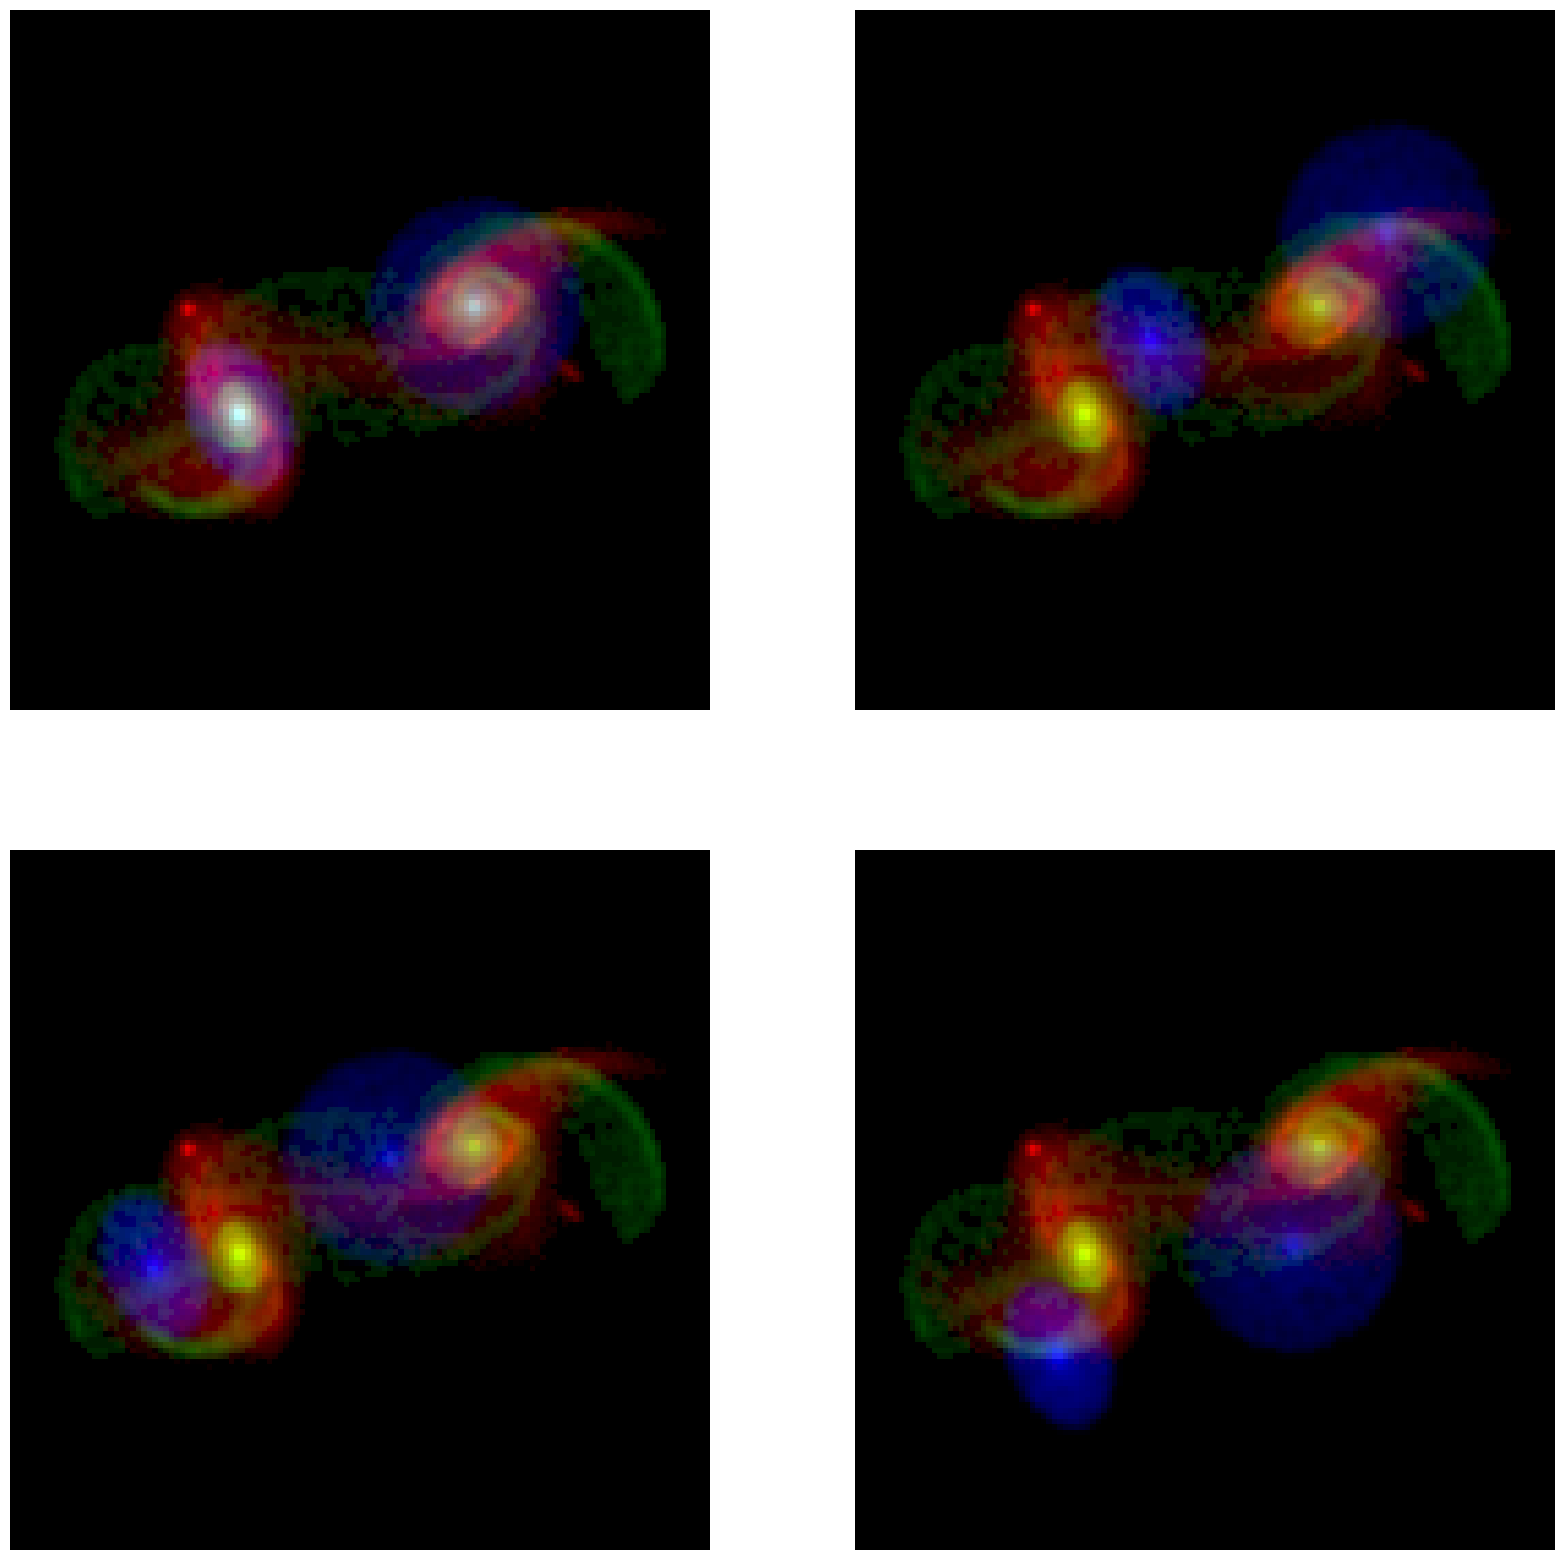

In [53]:

def offset_img( img_in, std_dev=2 ):
    img = np.copy(img_in)

    # starting locations of triangle corners
    s = img.shape
    ls = np.array( [[s[0]/2, s[1]/2], [ s[0], s[1]/2], [s[0]/2, s[1] ]] ).astype(np.float32)  # center, top, right

    # Build warp matrix and apply warp on each image
    for i in range(3):

        # destination locations of triage corners
        ld = np.copy( ls )

        # Pixel offset of each channel
        r = np.random.normal( 0, std_dev, size=(2))
        for i in range(3):
            ld[i] += r

        warp_mat = cv2.getAffineTransform( ls, ld )
        img[:,:,i] = cv2.warpAffine(img[:,:,i], warp_mat, (img.shape[1], img.shape[0]))

        return img


if buildEnv and showPlots:
    import cv2, random
    import matplotlib.pyplot as plt

    # Load a single image as our example
    img = X[0,:,:]

    
    # Create 10 warped images
    imgList = [ img ]
    for i in range(3):
        imgList.append( offset_img( img, std_dev = 10 ) )

    # Set plot size
    plt.rcParams["figure.figsize"] = (20,20)

    # Plot 4 images
    fig, axs = plt.subplots(2,2)
    for i in range(4):
        axs[i//2,i%2].imshow( imgList[i].astype( np.uint8 ) )
        axs[i//2,i%2].axis('off')


## Prepare Data Generator and Initialize Results File

In [45]:
with strategy.scope(): 

    # Build custom image modification function
    def mod_image( img ):
        if args.noise:  img = add_noise( img )
        if args.warp_image:  img = warp_affine( img )
        if args.channel_offset:  img = offset_img( img )
        return img
        
    # Quick prediction to test functionality
    if buildEnv: 
        print( "Starting Predictions: ", model.predict( X[:4] )[:,0] )
        
    if args.data_gen: 
        print( "Using Data Generator with Noise:" )

        data_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.1,
            horizontal_flip=True,
            preprocessing_function=mod_image,
        )
    else: 
        print( "Data As Is:" )
        data_generator = keras.preprocessing.image.ImageDataGenerator()

    dg_trainer = data_generator.flow( 
            X, Y, 
            batch_size = args.batch_size
        )
    
    allLoss = []
    valLoss = []

    trainCorr = []
    testCorr = []
    extCorr = []
    
    print( 'Ready to Train:' )
    print( 'runName: %s' % args.runName )
    print( 'start: %d' % args.start )
    print( 'goal: %d' % args.stop )
    print( 'steps: %d' % args.num_epochs )

    with open( 'results/%s.txt' % args.runName, 'w' ) as f: 

        print( 'runName: %s' % args.runName, file=f )
        print( 'start: %d' % args.start, file=f )
        print( 'goal: %d' % args.stop, file=f )

2023-11-14 09:17:18.212826: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_22970"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:67"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

1/1 [==============================] - 2s 2s/step
Starting Predictions:  [0.49405906 0.49095052 0.48833075 0.49270397]
Using Data Generator with Noise:
Ready to Train:
runName: dl-s2-test
start: 0
goal: 1
steps: 1


## Train Model

In [46]:
if args.keras_tuner == "False" or args.keras_tuner == False:

    with strategy.scope():
        
        # Initialize iter
        i = args.start   
        
        while i < args.stop:

            history = model.fit(
            dg_trainer,
                validation_data = ( Xval, Yval ),
                epochs     = args.num_epochs,
                verbose    = args.verbose,
            )

            i += args.num_epochs
            timeid = int( time.time() )
            
            # Save loss
            allLoss = np.append( allLoss, history.history['loss'] )
            valLoss = np.append( valLoss, history.history['val_loss'] )

            # Calculate Correlations
            pTrainScores = model.predict( X )
            pTestScores = model.predict( Xval )

            trainCorr = np.corrcoef(  Y[:,0], pTrainScores[:,0] )[0,1]
            testCorr = np.corrcoef(  Yval[:,0], pTestScores[:,0] )[0,1]
            
            # Print Progress
            print( 'Progress: %d - %d' % ( i, args.stop ) )

            # Print Loss
            print( "Training Loss:",*["%.8f"%(x) for x in history.history['loss']])    
            print( "Test Loss:",*["%.8f"%(x) for x in history.history['val_loss']])

            # external loss
            if type(Xext) != type(None): 

                # Get external loss
                extLoss = model.evaluate( Xext, Yext, verbose=0 )
                print( "External Loss:", extLoss )

            # Print correlations
            print( "Train Correlation:", trainCorr )
            print( "Test Correlation:", testCorr )
            
            # If also using external validation
            if type(Xext) != type(None): 

                # Get external correlation
                pExtScores = model.predict( Xext )
                extCorr = np.corrcoef(  Yext[:], pExtScores[:,0] )[0,1]
                print( "External Correlation:", extCorr )


            with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

                print( 'Progress: %d - %d' % ( i, timeid ), file=f )
                print( "Training accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
                print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)
                print( "Train Correlation:", trainCorr, file=f )
                print( "Test Correlation:", testCorr, file=f )
                if type(Xext) != type(None): 
    
                    print( "External Correlation:", extCorr, file=f )
            # End writing to results file
            
            # Save model
            if args.save_model: 
                model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )
                
        # End while Training



2023-11-14 09:17:27.268502: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_24868"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:85"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -

132/132 [==============================] - ETA: 0s - loss: 0.0589

2023-11-14 09:20:08.172620: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_37323"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:106"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

132/132 [==============================] - 169s 1s/step - loss: 0.0589 - val_loss: 0.0317


2023-11-14 09:20:17.909477: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_39368"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:125"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

132/132 [==============================] - 28s 212ms/step


2023-11-14 09:20:46.333846: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_40543"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:144"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

33/33 [==============================] - 7s 211ms/step
Progress: 1 - 1
Training Loss: 0.05893051
Test Loss: 0.03165635
Train Correlation: 0.8040344148532316
Test Correlation: 0.81628689386451


## View Ongoing Loss and Predictions

dict_keys(['loss', 'val_loss'])


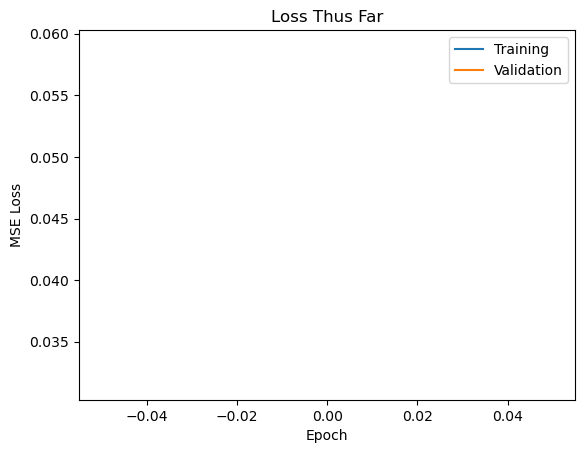

: 

In [ ]:
if buildEnv and args.keras_tuner == "False": 
    import matplotlib.pyplot as plt
    print( history.history.keys() )
    plt.plot( allLoss )
    plt.plot( valLoss )
    plt.title ("Loss Thus Far")
    plt.legend(['Training','Validation'])
    plt.xlabel('Epoch')
    plt.ylabel ('MSE Loss')
    #plt.ylim([0,1])
    plt.show()


In [ ]:
print( valLoss )

[0.03165635]


In [54]:
if buildEnv and args.keras_tuner == "False": 
    
    pTestScores = model.predict( Xval )
    pTrainScores = model.predict( X )

    print( Y.shape, Yval.shape )
    print( pTestScores.shape, pTrainScores.shape )

    trainCorr = np.corrcoef(  Y[:,0], pTrainScores[:,0] )[0,1]
    testCorr = np.corrcoef(  Yval[:,0], pTestScores[:,0] )[0,1]
    print( trainCorr, testCorr )

2023-11-14 09:29:19.190459: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_44068"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:201"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

33/33 [==============================] - 7s 213ms/step


2023-11-14 09:29:27.456368: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_44451"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:220"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

132/132 [==============================] - 28s 208ms/step
(4224, 1) (1056, 1)
(1056, 1) (4224, 1)
0.8040344148532316 0.81628689386451


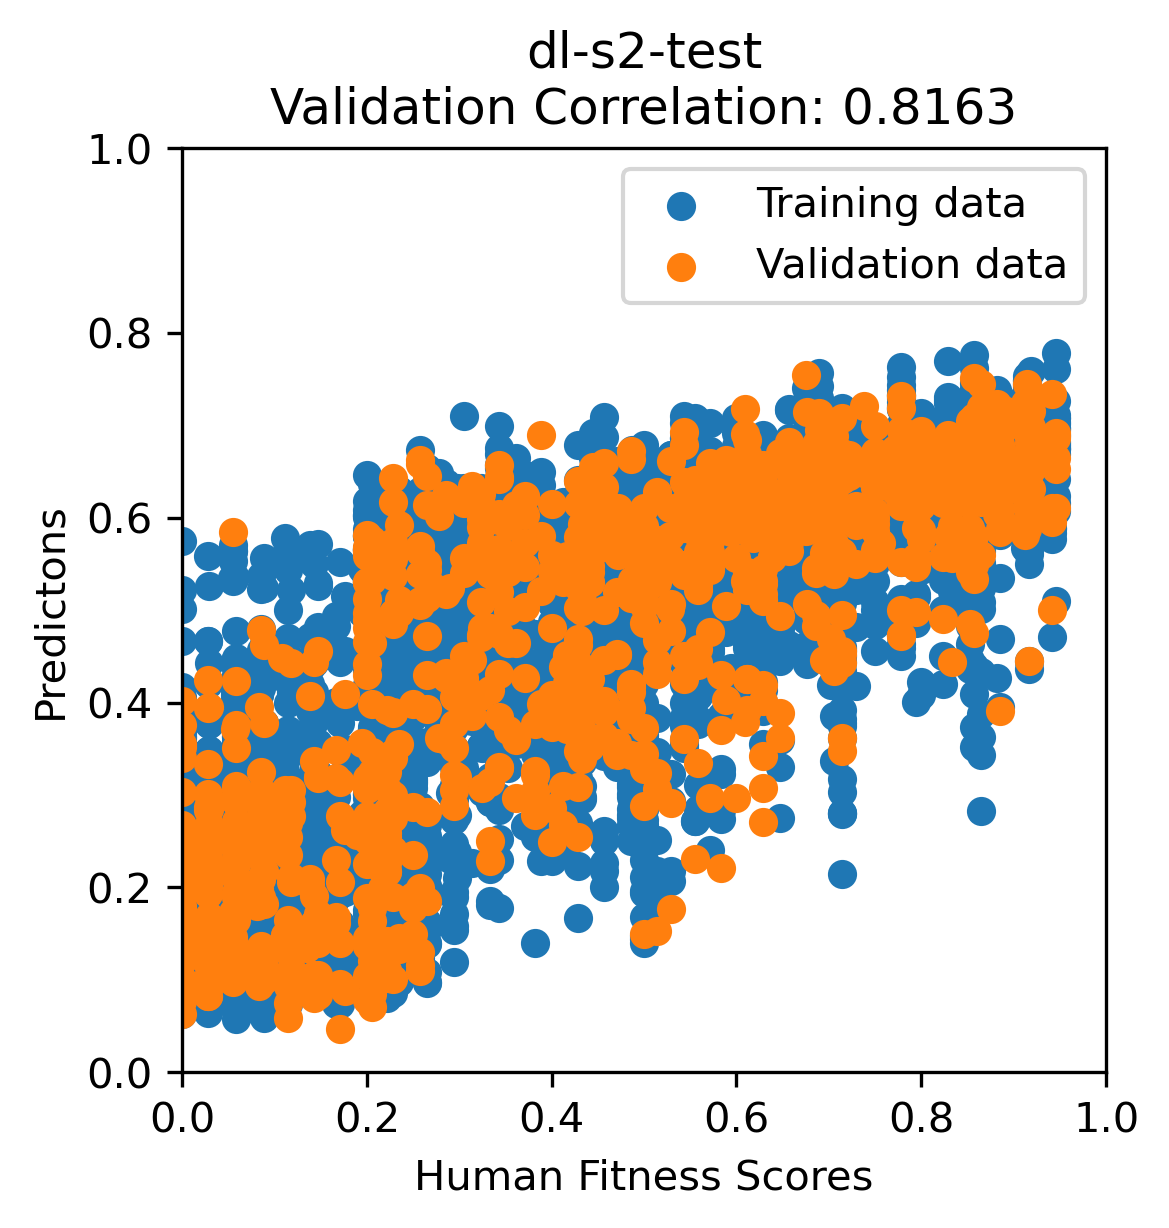

In [56]:
if buildEnv and args.keras_tuner == "False": 

    plt.figure(figsize=(4,4), dpi=300)
    plt.scatter( Y[:,0], pTrainScores, label='Training data' ) 
    plt.scatter( Yval[:,0], pTestScores, label='Validation data' )
    
    plt.xlabel('Human Fitness Scores')
    plt.ylabel('Predictons')
    plt.title("%s\nValidation Correlation: %.4f"% (args.runName, testCorr))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()

    plt.gca().set_aspect('equal')


# Continue Training?

In [57]:
with strategy.scope():
    
    if buildEnv and args.keras_tuner == "False": 
    
        scale = 1.0
        args.num_epochs = 10
        print( 'LR Before: %f' % args.learning_rate )
        args.learning_rate *= scale
        print( "LR After: % ", args.learning_rate )
        keras.backend.set_value( 
            model.optimizer.learning_rate, 
            float( args.learning_rate ) 
        )

        history = model.fit(
           dg_trainer,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )

        # Save loss
        allLoss = np.append( allLoss, history.history['loss'] )
        valLoss = np.append( valLoss, history.history['val_loss'] ) 

        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Validation accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


LR Before: 0.000100
LR After: %  0.0001


2023-11-14 09:30:23.459445: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_45625"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:236"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 0.0337

2023-11-14 09:32:52.776857: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_46176"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:257"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

132/132 [==============================] - 156s 1s/step - loss: 0.0337 - val_loss: 0.0207
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.0279

2023-11-14 09:35:27.256154: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


132/132 [==============================] - 155s 1s/step - loss: 0.0279 - val_loss: 0.0198
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.0268

2023-11-14 09:38:03.183034: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


132/132 [==============================] - 156s 1s/step - loss: 0.0268 - val_loss: 0.0189
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.0248

2023-11-14 09:40:37.226058: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


132/132 [==============================] - 153s 1s/step - loss: 0.0248 - val_loss: 0.0177
Epoch 5/10
 71/132 [===============>..............] - ETA: 1:06 - loss: 0.0228

# Save Model?

In [ ]:
   
if buildEnv and args.save_model and args.keras_tuner == "False": 
    model.save( 'models/%s.h5' % args.runName , save_format='h5' )

    with open( 'results/%s.txt' % args.runName , 'w' ) as f: 

        print( 'Progress: %d - %d' % ( i, timeid ), file=f )
        print( "Validation accuracy:",*["%.8f"%(x) for x in allLoss], file=f)    
        print( "Test accuracy:",*["%.8f"%(x) for x in valLoss],file=f)

        
print("Model and Results Saved")

NameError: name 'buildEnv' is not defined

## Keras Tuner?

In [ ]:
def build( hp ):
    
    cmdStr = ''
    cmdStr += ' -runName %s' % args.runName
    cmdStr += ' -start %d' % args.start
    cmdStr += ' -stop %d' % args.stop
    cmdStr += ' -num_epochs %d' % args.num_epochs
    
    cmdStr += ' -learning_rate %f' % hp.Float("lr", default=0.0001, min_value=1e-6, max_value=.01, sampling="log")
    cmdStr += ' -pool %s'          % hp.Choice("pool", [ 'None', 'avg', 'max' ], default=None,  )
    cmdStr += ' -f_depth %d'       % hp.Int( 'f_depth', default=3, min_value=1, max_value=8, step=1 )
    cmdStr += ' -output_activation %s' % hp.Choice( 'output_activation', default='linear', \
                                                   values=[ 'linear', 'sigmoid', 'softmax', 'None' ] )

    
    print ("Parsing Tuner Args")
    tArgs = parser.parse_args(cmdStr.split())

    tModel = buildModel( tArgs, X, Y )
    print ('Tuner Model: ', tModel )
    
    return tModel
    
if args.keras_tuner == 'True':
    
    import keras_tuner as kt

    with strategy.scope():

        print ("Building Tuner: ")
        hp = kt.HyperParameters()

        tuner = kt.Hyperband(
             build,
             objective=kt.Objective("val_loss", direction="min"),
             max_epochs=args.stop,
             factor=5,
             hyperband_iterations=5,
             directory='tuner',
             project_name=args.runName)

        print ("Tuner Searching: ", )
        tuner.search( dg_trainer, epochs=args.num_epochs, validation_data=(Xval, Yval))


Building Tuner: 
INFO:tensorflow:Reloading Tuner from tuner/untitled_project/tuner0.json
Tuner Searching: 

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1.322e-05         |8.1323e-05        |lr
avg               |max               |pool
3                 |1                 |f_depth
40                |24                |f_width
relu              |relu              |f_activation
sigmoid           |linear            |output_activation
efficientNetB1    |efficientNetB1    |model
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Parsing Tuner Args
Tuner Model:  <keras.engine.functional.Functional object at 0x7fdbccade740>
Epoch 1/2
115/132 [=========================>....] - ETA: 5s - loss: 0.1027